In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils.globals import PATH_TO_ROOT

MPS not available because the current PyTorch install was not built with MPS enabled.


In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize images to 224x224 for pretrained models
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize with MNIST mean and std
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert 1-channel grayscale to 3-channel
])

In [6]:
# Download and load the training and test datasets
# pass the root folder, as it will create the directory MNIST automatically
train_dataset = datasets.MNIST(root=PATH_TO_ROOT, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=PATH_TO_ROOT, train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9.91M/9.91M [00:15<00:00, 627kB/s] 


Extracting C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw\train-images-idx3-ubyte.gz to C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw\train-labels-idx1-ubyte.gz to C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.37MB/s]


Extracting C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 146kB/s]

Extracting C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\PYTHON\federated-neuromophic\MNIST_DATA\MNIST\raw



In [7]:
# Define training and validation indices
validation_split = 0.1
shuffle_dataset = True
random_seed = 42

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Create data samplers and loaders
batch_size = 128

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Load a non-pretrained ResNet18 model
model = models.resnet18(pretrained=False)

# Modify the final layer to match the number of classes in MNIST
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # MNIST has 10 classes (digits 0-9)

# Move the model to the appropriate device
model = model.to(device)

C:\Users\Lorenzo\miniconda3\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lorenzo\miniconda3\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [11]:
num_epochs = 3

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_acc = 0.0


for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Initialize the progress bar for training
    train_progress_bar = tqdm(train_loader, desc='Training', leave=False)

    for images, labels in train_progress_bar:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with current loss and accuracy
        batch_acc = 100 * (predicted == labels).sum().item() / labels.size(0)
        train_progress_bar.set_postfix({'Batch Loss': loss.item(), 'Batch Acc': f'{batch_acc:.2f}%'})

    epoch_loss = running_loss / len(train_indices)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    # Initialize the progress bar for validation
    val_progress_bar = tqdm(validation_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for images, labels in val_progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar with current loss
            val_progress_bar.set_postfix({'Batch Loss': loss.item()})

    val_loss = val_loss / len(val_indices)
    val_acc = 100 * correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    valid_losses.append(val_loss)
    valid_accuracies.append(val_acc)

    # Print epoch statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')

    # Step the scheduler
    scheduler.step()

Epoch [1/3]


Epoch [1/3]
Current Learning Rate: 0.001000
Train Loss: 0.0604, Train Acc: 98.16% | Val Loss: 0.0764, Val Acc: 97.68%

Epoch [2/3]


Epoch [2/3]
Current Learning Rate: 0.000100
Train Loss: 0.0201, Train Acc: 99.39% | Val Loss: 0.0207, Val Acc: 99.42%

Epoch [3/3]


Epoch [3/3]
Current Learning Rate: 0.000010
Train Loss: 0.0139, Train Acc: 99.60% | Val Loss: 0.0197, Val Acc: 99.40%



In [12]:
# Testing the model with progress bar
model.eval()
correct = 0
total = 0

# Initialize the progress bar for testing
test_progress_bar = tqdm(test_loader, desc='Testing', leave=False)

with torch.no_grad():
    for images, labels in test_progress_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with current accuracy
        current_accuracy = 100 * correct / total
        test_progress_bar.set_postfix({'Accuracy': f'{current_accuracy:.2f}%'})

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 99.54%


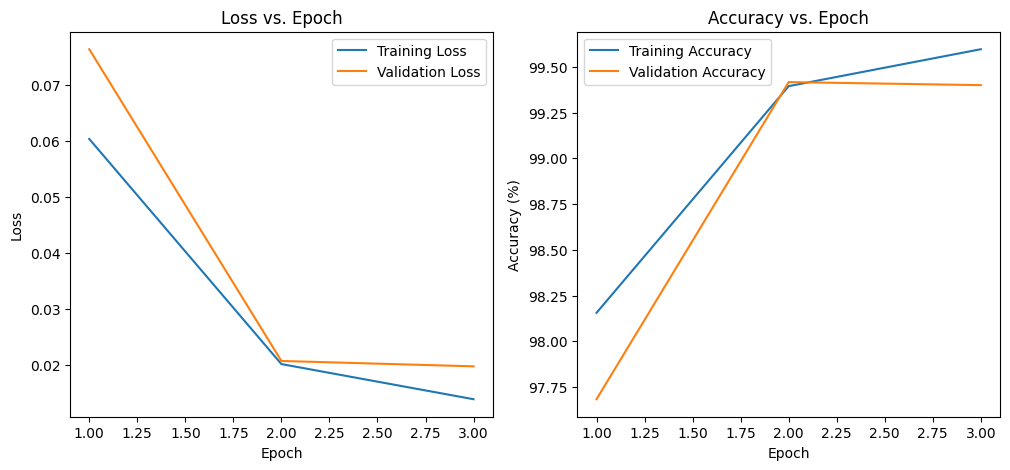

In [13]:
# Plot loss curves
plt.figure(figsize=(12, 5))
x = range(1, num_epochs+1)
plt.subplot(1, 2, 1)
plt.plot(x, train_losses, label='Training Loss')
plt.plot(x, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(x, train_accuracies, label='Training Accuracy')
plt.plot(x, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()